# Single Day Backtest - Per Player Models

This notebook walks through a single day backtest using per-player models to investigate model behavior and data quality.

## Methodology

1. Load historical training data up to target date
2. Build features using rolling statistics (shift -1 to prevent lookahead bias)
3. Train separate XGBoost model per player on historical data
4. Generate predictions for target slate using per-player models
5. Compare predictions to actual results
6. Analyze errors and feature importance

In [25]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

repo_root = Path.cwd().parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from src.data.storage.sqlite_storage import SQLiteStorage
from src.data.loaders.historical_loader import HistoricalDataLoader
from src.models.xgboost_model import XGBoostModel
from src.features.pipeline import FeaturePipeline
from src.features.transformers.rolling_stats import RollingStatsTransformer
from src.features.transformers.ewma import EWMATransformer
from src.utils.fantasy_points import calculate_dk_fantasy_points
from src.evaluation.metrics.accuracy import MAPEMetric, RMSEMetric, CorrelationMetric

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 100)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Configuration

In [26]:
from src.utils.feature_config import load_feature_config

DB_PATH = repo_root / 'nba_dfs.db'
TARGET_DATE = '20250205'
NUM_SEASONS = 1
MIN_GAMES = 10
FEATURE_CONFIG = 'default_features'

feature_config = load_feature_config(FEATURE_CONFIG)

if NUM_SEASONS == 1:
    TRAIN_START = HistoricalDataLoader.get_season_start_date(TARGET_DATE)
else:
    TRAIN_START = HistoricalDataLoader.get_previous_season_start_date(TARGET_DATE)

target_dt = datetime.strptime(TARGET_DATE, '%Y%m%d')
train_end_dt = target_dt - timedelta(days=1)
TRAIN_END = train_end_dt.strftime('%Y%m%d')

print(f"Database: {DB_PATH}")
print(f"Target slate date: {TARGET_DATE}")
print(f"Num seasons for training: {NUM_SEASONS}")
print(f"Training period: {TRAIN_START} to {TRAIN_END}")
print(f"  (Season start based on NBA season: Oct 1)")
print(f"\nFeature Configuration: {feature_config.name}")
print(f"  Description: {feature_config.description}")
print(f"  Version: {feature_config.version}")
print(f"  Stats: {len(feature_config.stats)} features")
print(f"  Rolling windows: {feature_config.rolling_windows}")
print(f"  EWMA span: {feature_config.ewma_span}")
print(f"  Min games per player: {MIN_GAMES}")

Database: c:\Users\antho\OneDrive\Documents\Repositories\delapan-fantasy\nba_dfs.db
Target slate date: 20250205
Num seasons for training: 1
Training period: 20241001 to 20250204
  (Season start based on NBA season: Oct 1)

Feature Configuration: Default Feature Set
  Description: Full feature set with all available stats, rolling windows, and EWMA
  Version: 2.0.0
  Stats: 21 features
  Rolling windows: [3, 5, 10]
  EWMA span: 5
  Min games per player: 10


## Load Data

Load historical training data and target slate data.

In [27]:
storage = SQLiteStorage(str(DB_PATH))
loader = HistoricalDataLoader(storage)

print("Loading training data...")
training_data = loader.load_historical_player_logs(start_date=TRAIN_START, end_date=TRAIN_END)

if 'plusMinus' in training_data.columns:
    training_data['plusMinus'] = training_data['plusMinus'].apply(lambda x: int(x) if pd.notna(x) else 0)

print(f"Loaded {len(training_data)} training samples")
print(f"Date range: {training_data['gameDate'].min()} to {training_data['gameDate'].max()}")
print(f"Unique players: {training_data['playerID'].nunique()}")

print("\nLoading target slate...")
slate_data = loader.load_slate_data(TARGET_DATE)
salaries_df = slate_data.get('dfs_salaries', pd.DataFrame())

if not salaries_df.empty and 'platform' in salaries_df.columns:
    salaries_df = salaries_df[salaries_df['platform'].str.lower() == 'draftkings']
    print(f"Filtered to DraftKings platform")

print(f"Slate has {len(salaries_df)} players")

training_data.head()

Loading training data...
Loaded 15874 training samples
Date range: 2024-10-22 00:00:00 to 2025-02-03 00:00:00
Unique players: 528

Loading target slate...


Filtered to DraftKings platform
Slate has 380 players


,playerID,longName,team,teamAbv,teamID,gameID,gameDate,pos,mins,pts,reb,ast,stl,blk,TOV,PF,fga,fgm,fgp,fta,ftm,ftp,tptfga,tptfgm,tptfgp,OffReb,DefReb,fantasyPoints,fantasyPts,plusMinus,usage,tech,created_at
0,28968646399,Rui Hachimura,LAL,LAL,14,20241022_MIN@LAL,2024-10-22,,35,18,5,1,2,1,0,2,14,7,50.0,4,3,75.0,4,1,25.0,3,2,34.75,,19,19.13,0,2025-10-06 12:32:44
1,28828385129,Gabe Vincent,LAL,LAL,14,20241022_MIN@LAL,2024-10-22,,17,2,2,2,0,0,2,1,2,1,50.0,0,0,0,0,0,0,0,2,5.5,,-2,9.99,0,2025-10-06 12:32:44
2,28858866027,Naz Reid,MIN,MIN,18,20241022_MIN@LAL,2024-10-22,,26,12,4,1,0,0,1,3,8,3,37.5,4,4,100.0,4,2,50.0,1,3,17.5,,-6,17.6,0,2025-10-06 12:32:44
3,942947235539,Max Christie,LAL,LAL,14,20241022_MIN@LAL,2024-10-22,,11,2,2,0,0,0,0,5,3,0,0.0,2,2,100.0,3,0,0.0,1,1,4.5,,-5,14.98,0,2025-10-06 12:32:44
4,28236562792,Mike Conley,MIN,MIN,18,20241022_MIN@LAL,2024-10-22,,20,5,4,2,1,0,3,1,7,1,14.3,3,3,100.0,5,0,0.0,2,2,13.0,,-22,24.07,0,2025-10-06 12:32:44


## Feature Engineering

Build features using FeaturePipeline:
- Rolling statistics (mean, std) with shift(1) to prevent lookahead bias
- EWMA with shift(1)
- Target shifted forward by 1 game

In [28]:
df = training_data.copy()
df['gameDate'] = pd.to_datetime(df['gameDate'], format='%Y%m%d', errors='coerce')
df = df.sort_values(['playerID', 'gameDate'])

if 'plusMinus' in df.columns:
    df['plusMinus'] = df['plusMinus'].apply(lambda x: int(x) if pd.notna(x) else 0)

if 'fpts' not in df.columns:
    print("Calculating fantasy points...")
    df['fpts'] = df.apply(calculate_dk_fantasy_points, axis=1)

print(f"Fantasy points - min: {df['fpts'].min():.1f}, max: {df['fpts'].max():.1f}, mean: {df['fpts'].mean():.1f}")

print("Shifting target forward by 1 game per player...")
df['target'] = df.groupby('playerID')['fpts'].shift(-1)

print(f"\nBuilding features from config: {feature_config.name}")
print(f"Stats: {feature_config.stats}")
print(f"Rolling windows: {feature_config.rolling_windows}")
print(f"EWMA span: {feature_config.ewma_span}")

print("\nBuilding feature pipeline...")
pipeline = feature_config.build_pipeline(FeaturePipeline)

print("Applying transformations...")
df = pipeline.fit_transform(df)

print("Removing original numeric columns...")
df = df.drop(columns=feature_config.stats, errors='ignore')

print(f"Features created: {df.shape[1]} columns")
df.head()

Calculating fantasy points...
Fantasy points - min: -1.5, max: 97.0, mean: 21.2
Shifting target forward by 1 game per player...

Building features from config: Default Feature Set
Stats: ['pts', 'reb', 'ast', 'stl', 'blk', 'TOV', 'mins', 'PF', 'fga', 'fgm', 'fgp', 'fta', 'ftm', 'ftp', 'tptfga', 'tptfgm', 'tptfgp', 'OffReb', 'DefReb', 'usage', 'plusMinus']
Rolling windows: [3, 5, 10]
EWMA span: 5

Building feature pipeline...
Applying transformations...


Removing original numeric columns...
Features created: 161 columns


,playerID,longName,team,teamAbv,teamID,gameID,gameDate,pos,fantasyPoints,fantasyPts,tech,created_at,fpts,target,pts_ma3,pts_std3,pts_ma5,pts_std5,pts_ma10,pts_std10,reb_ma3,reb_std3,reb_ma5,reb_std5,reb_ma10,reb_std10,ast_ma3,ast_std3,ast_ma5,ast_std5,ast_ma10,ast_std10,stl_ma3,stl_std3,stl_ma5,stl_std5,stl_ma10,stl_std10,blk_ma3,blk_std3,blk_ma5,blk_std5,blk_ma10,blk_std10,TOV_ma3,TOV_std3,TOV_ma5,TOV_std5,TOV_ma10,TOV_std10,...,tptfgp_std3,tptfgp_ma5,tptfgp_std5,tptfgp_ma10,tptfgp_std10,OffReb_ma3,OffReb_std3,OffReb_ma5,OffReb_std5,OffReb_ma10,OffReb_std10,DefReb_ma3,DefReb_std3,DefReb_ma5,DefReb_std5,DefReb_ma10,DefReb_std10,usage_ma3,usage_std3,usage_ma5,usage_std5,usage_ma10,usage_std10,plusMinus_ma3,plusMinus_std3,plusMinus_ma5,plusMinus_std5,plusMinus_ma10,plusMinus_std10,pts_ewma5,reb_ewma5,ast_ewma5,stl_ewma5,blk_ewma5,TOV_ewma5,mins_ewma5,PF_ewma5,fga_ewma5,fgm_ewma5,fgp_ewma5,fta_ewma5,ftm_ewma5,ftp_ewma5,tptfga_ewma5,tptfgm_ewma5,tptfgp_ewma5,OffReb_ewma5,DefReb_ewma5,usage_ewma5,plusMinus_ewma5
218,28006619932,Brook Lopez,MIL,MIL,17,20241023_MIL@PHI,2024-10-23,,43.0,,0,2025-10-06 12:32:44,39.00,18.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
424,28006619932,Brook Lopez,MIL,MIL,17,20241025_CHI@MIL,2024-10-25,,20.5,,0,2025-10-06 12:32:44,18.50,23.50,10.000000,NaN,10.000000,NaN,10.000000,NaN,8.000000,NaN,8.000000,NaN,8.000000,NaN,6.000000,NaN,6.000000,NaN,6.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,6.000000,NaN,6.00,NaN,6.00,NaN,4.000000,NaN,4.000000,NaN,4.000000,NaN,...,NaN,16.700000,NaN,16.700000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,7.000000,NaN,7.00,NaN,7.00,NaN,20.760000,NaN,20.760000,NaN,20.760000,NaN,18.000000,NaN,18.000000,NaN,18.000000,NaN,10.000000,8.000000,6.000000,0.000000,6.000000,4.000000,36.000000,4.000000,11.000000,3.000000,27.300000,4.000000,3.000000,75.000000,6.000000,1.000000,16.700000,1.000000,7.000000,20.760000,18.000000
886,28006619932,Brook Lopez,MIL,MIL,17,20241027_MIL@BKN,2024-10-27,,25.0,,0,2025-10-06 12:32:45,23.50,32.50,8.500000,2.121320,8.500000,2.121320,8.500000,2.121320,6.000000,2.828427,6.000000,2.828427,6.000000,2.828427,3.500000,3.535534,3.500000,3.535534,3.500000,3.535534,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.500000,2.121320,4.50,2.12132,4.50,2.12132,3.000000,1.414214,3.000000,1.414214,3.000000,1.414214,...,0.000000,16.700000,0.000000,16.700000,0.000000,0.500000,0.707107,0.500000,0.707107,0.500000,0.707107,5.500000,2.121320,5.50,2.121320,5.50,2.121320,19.335000,2.015254,19.335000,2.015254,19.335000,2.015254,4.500000,19.091883,4.500000,19.091883,4.500000,19.091883,9.000000,6.666667,4.333333,0.000000,5.000000,3.333333,33.666667,3.666667,10.666667,2.666667,24.866667,3.333333,2.666667,83.333333,6.000000,1.000000,16.700000,0.666667,6.000000,19.810000,9.000000
1095,28006619932,Brook Lopez,MIL,MIL,17,20241028_MIL@BOS,2024-10-28,,38.5,,0,2025-10-06 12:32:45,32.50,17.25,10.666667,4.041452,10.666667,4.041452,10.666667,4.041452,5.333333,2.309401,5.333333,2.309401,5.333333,2.309401,2.333333,3.214550,2.333333,3.214550,2.333333,3.214550,0.666667,1.154701,0.666667,1.154701,0.666667,1.154701,3.000000,3.000000,3.00,3.00000,3.00,3.00000,2.333333,1.527525,2.333333,1.527525,2.333333,1.527525,...,24.999267,31.133333,24.999267,31.133333,24.999267,0.333333,0.577350,0.333333,0.577350,0.333333,0.577350,5.000000,1.732051,5.00,1.732051,5.00,1.732051,18.113333,2.551085,18.113333,2.551085,18.113333,2.551085,2.333333,14.011900,2.333333,14.011900,2.333333,14.011900,11.000000,5.777778,2.888889,0.666667,3.333333,2.555556,32.111111,2.777778,10.111111,3.777778,38.811111,2.222222,1.777778,55.555556,5.666667,1.666667,31.133333,0.444444,5.333333,18.430000,5.333333
1541,28006619932,Brook Lo

In [29]:
print("Feature columns created:")
feature_cols_list = [col for col in df.columns if any(x in col for x in ['_ma', '_std', '_ewma'])]
print(f"Total: {len(feature_cols_list)}")
for col in sorted(feature_cols_list)[:20]:
    print(f"  {col}")
print("  ...")

Feature columns created:
Total: 147
  DefReb_ewma5
  DefReb_ma10
  DefReb_ma3
  DefReb_ma5
  DefReb_std10
  DefReb_std3
  DefReb_std5
  OffReb_ewma5
  OffReb_ma10
  OffReb_ma3
  OffReb_ma5
  OffReb_std10
  OffReb_std3
  OffReb_std5
  PF_ewma5
  PF_ma10
  PF_ma3
  PF_ma5
  PF_std10
  PF_std3
  ...


## Prepare Training Data Per Player

In [30]:
df = df.dropna(subset=['target'])

metadata_cols = ['playerID', 'playerName', 'team', 'pos', 'gameDate', 'fpts', 'target', 'pts', 'reb', 'ast', 'stl', 'blk', 'TOV', 'mins']
feature_cols = [col for col in df.columns if col not in metadata_cols and df[col].dtype in ['int64', 'float64', 'bool']]

print(f"Total training samples: {len(df)}")
print(f"Features: {len(feature_cols)}")

player_game_counts = df.groupby('playerID').size()
qualified_players = player_game_counts[player_game_counts >= MIN_GAMES].index

print(f"\nPlayers with >= {MIN_GAMES} games: {len(qualified_players)}")
print(f"Total players: {df['playerID'].nunique()}")

df_qualified = df[df['playerID'].isin(qualified_players)]
print(f"\nQualified training samples: {len(df_qualified)}")

Total training samples: 15346
Features: 147

Players with >= 10 games: 445
Total players: 521

Qualified training samples: 14979


## Train Per-Player Models

In [31]:
from src.utils.bayesian_optimizer import optimize_xgboost_cv
from joblib import Parallel, delayed

RUN_OPTIMIZATION = True
OPTIMIZE_PER_PLAYER = True
N_OPTIMIZATION_ITERATIONS = 20
CV_FOLDS = 3
MIN_SAMPLES_FOR_OPTIMIZATION = 30
N_JOBS = -1

def optimize_single_player(player_id, player_data, feature_cols, param_bounds, cv_folds, n_iterations):
    """Optimize hyperparameters for a single player."""
    X_player = player_data[feature_cols].fillna(0)
    y_player = player_data['target']
    
    try:
        best_params, best_score, history = optimize_xgboost_cv(
            X=X_player,
            y=y_player,
            param_bounds=param_bounds,
            cv_folds=cv_folds,
            n_iterations=n_iterations,
            scoring='neg_mean_absolute_error',
            random_state=42,
            verbose=False
        )
        
        config = {
            'max_depth': int(best_params['max_depth']),
            'learning_rate': float(best_params['learning_rate']),
            'n_estimators': int(best_params['n_estimators']),
            'min_child_weight': int(best_params['min_child_weight']),
            'subsample': float(best_params['subsample']),
            'colsample_bytree': float(best_params['colsample_bytree']),
            'gamma': float(best_params['gamma']),
            'reg_alpha': float(best_params['reg_alpha']),
            'reg_lambda': float(best_params['reg_lambda']),
            'objective': 'reg:squarederror',
            'random_state': 42,
            'enable_categorical': True
        }
        
        summary = {
            'playerID': player_id,
            'num_games': len(X_player),
            'cv_mae': -best_score,
            'max_depth': config['max_depth'],
            'learning_rate': config['learning_rate'],
            'n_estimators': config['n_estimators'],
            'success': True,
            'error': None
        }
        
        return player_id, config, summary
        
    except Exception as e:
        return player_id, None, {
            'playerID': player_id,
            'num_games': len(player_data),
            'cv_mae': None,
            'max_depth': None,
            'learning_rate': None,
            'n_estimators': None,
            'success': False,
            'error': str(e)
        }

if RUN_OPTIMIZATION and not OPTIMIZE_PER_PLAYER:
    print("Running global Bayesian optimization on subset of data...")
    print(f"This may take a while (CV folds: {CV_FOLDS}, iterations: {N_OPTIMIZATION_ITERATIONS})...")
    
    sample_size = min(5000, len(df_qualified))
    df_sample = df_qualified.sample(n=sample_size, random_state=42)
    
    X_sample = df_sample[feature_cols].fillna(0)
    y_sample = df_sample['target']
    
    print(f"Optimizing on {len(X_sample)} samples")
    
    param_bounds = {
        'max_depth': (3, 10),
        'learning_rate': (0.01, 0.3),
        'n_estimators': (50, 500),
        'min_child_weight': (1, 10),
        'subsample': (0.5, 1.0),
        'colsample_bytree': (0.5, 1.0),
        'gamma': (0.0, 5.0),
        'reg_alpha': (0.0, 1.0),
        'reg_lambda': (0.0, 1.0)
    }
    
    best_params, best_score, history = optimize_xgboost_cv(
        X=X_sample,
        y=y_sample,
        param_bounds=param_bounds,
        cv_folds=CV_FOLDS,
        n_iterations=N_OPTIMIZATION_ITERATIONS,
        scoring='neg_mean_absolute_error',
        random_state=42,
        verbose=True
    )
    
    print("\n" + "=" * 50)
    print("Optimization Complete")
    print("=" * 50)
    print(f"Best CV Score (MAE): {-best_score:.4f}")
    print("\nBest Parameters:")
    for param, value in sorted(best_params.items()):
        print(f"  {param}: {value}")
    
    optimized_config = {
        'max_depth': int(best_params['max_depth']),
        'learning_rate': float(best_params['learning_rate']),
        'n_estimators': int(best_params['n_estimators']),
        'min_child_weight': int(best_params['min_child_weight']),
        'subsample': float(best_params['subsample']),
        'colsample_bytree': float(best_params['colsample_bytree']),
        'gamma': float(best_params['gamma']),
        'reg_alpha': float(best_params['reg_alpha']),
        'reg_lambda': float(best_params['reg_lambda']),
        'objective': 'reg:squarederror',
        'random_state': 42,
        'enable_categorical': True
    }
    
    print("\nTop 10 iterations by score:")
    print(history.nlargest(10, 'score')[['score', 'max_depth', 'learning_rate', 'n_estimators']])
    
    per_player_configs = None
    
elif RUN_OPTIMIZATION and OPTIMIZE_PER_PLAYER:
    print("Running per-player Bayesian optimization with parallel processing...")
    print(f"Using {N_JOBS} CPU cores (-1 = all available)")
    print(f"CV folds: {CV_FOLDS}, iterations: {N_OPTIMIZATION_ITERATIONS} per player")
    print(f"Optimizing for players with >= {MIN_SAMPLES_FOR_OPTIMIZATION} games only")
    print()
    
    param_bounds = {
        'max_depth': (3, 10),
        'learning_rate': (0.01, 0.3),
        'n_estimators': (50, 300),
        'min_child_weight': (1, 10),
        'subsample': (0.5, 1.0),
        'colsample_bytree': (0.5, 1.0),
        'gamma': (0.0, 5.0),
        'reg_alpha': (0.0, 1.0),
        'reg_lambda': (0.0, 1.0)
    }
    
    players_to_optimize = []
    player_data_dict = {}
    
    for player_id in qualified_players:
        player_data = df_qualified[df_qualified['playerID'] == player_id]
        if len(player_data) >= MIN_SAMPLES_FOR_OPTIMIZATION:
            players_to_optimize.append(player_id)
            player_data_dict[player_id] = player_data
    
    print(f"Optimizing for {len(players_to_optimize)} players (out of {len(qualified_players)} total)")
    print("Starting parallel optimization...")
    print()
    
    results = Parallel(n_jobs=N_JOBS, verbose=10)(
        delayed(optimize_single_player)(
            player_id,
            player_data_dict[player_id],
            feature_cols,
            param_bounds,
            CV_FOLDS,
            N_OPTIMIZATION_ITERATIONS
        )
        for player_id in players_to_optimize
    )
    
    per_player_configs = {}
    optimization_summary = []
    
    for player_id, config, summary in results:
        if config is not None:
            per_player_configs[player_id] = config
        optimization_summary.append(summary)
    
    print("\n" + "=" * 50)
    print("Per-Player Optimization Complete")
    print("=" * 50)
    print(f"Successfully optimized: {len(per_player_configs)} players")
    
    opt_summary_df = pd.DataFrame(optimization_summary)
    successful = opt_summary_df[opt_summary_df['success'] == True]
    failed = opt_summary_df[opt_summary_df['success'] == False]
    
    if len(failed) > 0:
        print(f"Failed: {len(failed)} players")
        print("\nFailure details:")
        for _, row in failed.iterrows():
            print(f"  Player {row['playerID']}: {row['error']}")
    
    if len(successful) > 0:
        print("\nOptimization Summary (successful only):")
        print(f"  Mean CV MAE: {successful['cv_mae'].mean():.2f}")
        print(f"  Median CV MAE: {successful['cv_mae'].median():.2f}")
        print(f"  Std CV MAE: {successful['cv_mae'].std():.2f}")
        print(f"\nHyperparameter Distributions:")
        print(f"  max_depth: mean={successful['max_depth'].mean():.1f}, median={successful['max_depth'].median():.0f}, std={successful['max_depth'].std():.1f}")
        print(f"  learning_rate: mean={successful['learning_rate'].mean():.3f}, median={successful['learning_rate'].median():.3f}, std={successful['learning_rate'].std():.3f}")
        print(f"  n_estimators: mean={successful['n_estimators'].mean():.0f}, median={successful['n_estimators'].median():.0f}, std={successful['n_estimators'].std():.1f}")
        
        print("\nBest 10 optimizations (by CV MAE):")
        print(successful.nsmallest(10, 'cv_mae')[['playerID', 'num_games', 'cv_mae', 'max_depth', 'learning_rate', 'n_estimators']])
    
    optimized_config = None
    
else:
    print("Skipping Bayesian optimization (RUN_OPTIMIZATION = False)")
    print("Using default XGBoost hyperparameters for all players")
    optimized_config = None
    per_player_configs = None

Running per-player Bayesian optimization with parallel processing...
Using -1 CPU cores (-1 = all available)
CV folds: 3, iterations: 20 per player
Optimizing for players with >= 30 games only

Optimizing for 295 players (out of 445 total)
Starting parallel optimization...



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 262 out of 295 | elapsed:  4.2min remaining:   31.3s
[Parallel(n_jobs=-1)]: Done 292 out 


Per-Player Optimization Complete
Successfully optimized: 295 players

Optimization Summary (successful only):
  Mean CV MAE: 7.33
  Median CV MAE: 7.22
  Std CV MAE: 1.66

Hyperparameter Distributions:
  max_depth: mean=6.9, median=8, std=2.8
  learning_rate: mean=0.055, median=0.014, std=0.087
  n_estimators: mean=148, median=124, std=93.6

Best 10 optimizations (by CV MAE):
         playerID  num_games    cv_mae  max_depth  learning_rate  n_estimators
64    28358980482         34  2.892422         10       0.010000           300
286   94924449047         33  3.293615          3       0.042802           188
264  947940307989         30  3.389987         10       0.049689           294
204  942740191869         33  3.623023          9       0.300000           244
103   28598307499         34  3.834428          3       0.300000            50
170  940247765539         33  4.094851         10       0.080280           124
202  942541715989         49  4.247292         10       0.048918   

[Parallel(n_jobs=-1)]: Done 295 out of 295 | elapsed:  4.4min finished


## Optional: Bayesian Hyperparameter Optimization

Run Bayesian optimization to find optimal XGBoost hyperparameters. Set RUN_OPTIMIZATION = True to enable.

Note: This will significantly increase runtime (may take 30+ minutes depending on N_ITERATIONS).

In [32]:
player_models = {}
training_stats = []

print(f"Training models for {len(qualified_players)} players...")
if per_player_configs:
    print(f"Using per-player optimized hyperparameters for {len(per_player_configs)} players")
    print(f"Using default hyperparameters for remaining {len(qualified_players) - len(per_player_configs)} players")
elif optimized_config:
    print(f"Using global optimized hyperparameters")
else:
    print(f"Using default hyperparameters")
print()

for i, player_id in enumerate(qualified_players, 1):
    player_data = df_qualified[df_qualified['playerID'] == player_id]
    
    X_player = player_data[feature_cols].fillna(0)
    y_player = player_data['target']
    
    if len(X_player) < MIN_GAMES:
        continue
    
    if per_player_configs and player_id in per_player_configs:
        model = XGBoostModel(config=per_player_configs[player_id])
    elif optimized_config:
        model = XGBoostModel(config=optimized_config)
    else:
        model = XGBoostModel()
    
    model.train(X_player, y_player)
    player_models[player_id] = model
    
    training_stats.append({
        'playerID': player_id,
        'num_games': len(X_player),
        'mean_target': y_player.mean(),
        'std_target': y_player.std()
    })
    
    if i % 50 == 0:
        print(f"Trained {i}/{len(qualified_players)} models")

print(f"\nCompleted training {len(player_models)} player models")

training_stats_df = pd.DataFrame(training_stats)
print(f"\nTraining statistics:")
print(f"  Mean games per player: {training_stats_df['num_games'].mean():.1f}")
print(f"  Median games per player: {training_stats_df['num_games'].median():.1f}")
print(f"  Min games: {training_stats_df['num_games'].min()}")
print(f"  Max games: {training_stats_df['num_games'].max()}")

Training models for 445 players...
Using per-player optimized hyperparameters for 295 players
Using default hyperparameters for remaining 150 players

Trained 50/445 models
Trained 100/445 models
Trained 150/445 models
Trained 200/445 models
Trained 250/445 models
Trained 300/445 models
Trained 350/445 models
Trained 400/445 models

Completed training 445 player models

Training statistics:
  Mean games per player: 33.7
  Median games per player: 36.0
  Min games: 10
  Max games: 49


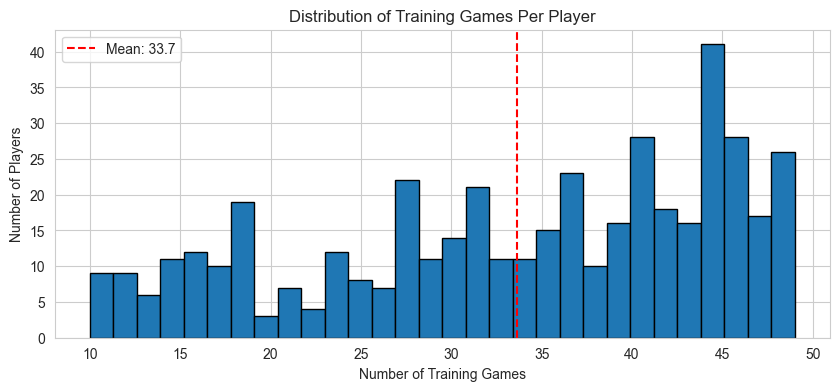

In [33]:
plt.figure(figsize=(10, 4))
plt.hist(training_stats_df['num_games'], bins=30, edgecolor='black')
plt.xlabel('Number of Training Games')
plt.ylabel('Number of Players')
plt.title('Distribution of Training Games Per Player')
plt.axvline(training_stats_df['num_games'].mean(), color='red', linestyle='--', label=f"Mean: {training_stats_df['num_games'].mean():.1f}")
plt.legend()
plt.show()

## Generate Slate Features

Build features for target slate using last available game for each player.

In [34]:
if 'longName' in salaries_df.columns and 'playerName' not in salaries_df.columns:
    salaries_df['playerName'] = salaries_df['longName']

training_data_for_slate = training_data.copy()
training_data_for_slate['gameDate'] = pd.to_datetime(training_data_for_slate['gameDate'], format='%Y%m%d', errors='coerce')

if 'fpts' not in training_data_for_slate.columns:
    training_data_for_slate['fpts'] = training_data_for_slate.apply(calculate_dk_fantasy_points, axis=1)

training_features = pipeline.transform(training_data_for_slate)

slate_features = []

for _, player_row in salaries_df.iterrows():
    player_id = player_row['playerID']
    
    player_features = training_features[training_features['playerID'] == player_id]
    
    if len(player_features) < min(feature_config.rolling_windows):
        continue
    
    last_row = player_features.iloc[-1]
    
    features = {
        'playerID': player_id,
        'playerName': player_row.get('playerName'),
        'team': player_row.get('team'),
        'pos': player_row.get('pos'),
        'salary': player_row.get('salary')
    }
    
    metadata_cols = ['playerID', 'playerName', 'team', 'pos', 'gameDate', 'fpts', 'pts', 'reb', 'ast', 'stl', 'blk', 'TOV', 'mins']
    for col in last_row.index:
        if col not in metadata_cols and training_features[col].dtype in ['int64', 'float64', 'bool']:
            features[col] = last_row[col]
    
    slate_features.append(features)

slate_features_df = pd.DataFrame(slate_features)
print(f"Generated features for {len(slate_features_df)} players")
slate_features_df.head()

C:\Users\antho\AppData\Local\Temp\ipykernel_45820\2862725814.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salaries_df['playerName'] = salaries_df['longName']


Generated features for 360 players


,playerID,playerName,team,pos,salary,PF,fga,fgm,fgp,fta,ftm,ftp,tptfga,tptfgm,tptfgp,OffReb,DefReb,plusMinus,usage,pts_ma3,pts_std3,pts_ma5,pts_std5,pts_ma10,pts_std10,reb_ma3,reb_std3,reb_ma5,reb_std5,reb_ma10,reb_std10,ast_ma3,ast_std3,ast_ma5,ast_std5,ast_ma10,ast_std10,stl_ma3,stl_std3,stl_ma5,stl_std5,stl_ma10,stl_std10,blk_ma3,blk_std3,blk_ma5,blk_std5,blk_ma10,blk_std10,TOV_ma3,...,tptfgp_std3,tptfgp_ma5,tptfgp_std5,tptfgp_ma10,tptfgp_std10,OffReb_ma3,OffReb_std3,OffReb_ma5,OffReb_std5,OffReb_ma10,OffReb_std10,DefReb_ma3,DefReb_std3,DefReb_ma5,DefReb_std5,DefReb_ma10,DefReb_std10,usage_ma3,usage_std3,usage_ma5,usage_std5,usage_ma10,usage_std10,plusMinus_ma3,plusMinus_std3,plusMinus_ma5,plusMinus_std5,plusMinus_ma10,plusMinus_std10,pts_ewma5,reb_ewma5,ast_ewma5,stl_ewma5,blk_ewma5,TOV_ewma5,mins_ewma5,PF_ewma5,fga_ewma5,fgm_ewma5,fgp_ewma5,fta_ewma5,ftm_ewma5,ftp_ewma5,tptfga_ewma5,tptfgm_ewma5,tptfgp_ewma5,OffReb_ewma5,DefReb_ewma5,usage_ewma5,plusMinus_ewma5
0,28908111729,Nikola Jokic,DEN,C,12800,2,13,9,69.2,10,8,80.0,3,1,33.3,1,13,11,22.42,24.333333,6.350853,25.2,6.534524,24.2,7.598245,9.333333,3.511885,8.6,4.159327,11.8,5.116422,12.000000,5.567764,12.2,4.086563,11.8,3.457681,2.666667,1.154701,1.8,1.483240,2.0,1.333333,0.666667,0.577350,0.6,0.547723,0.9,0.994429,4.000000,...,19.246385,42.64,16.892395,44.66,21.563560,1.000000,1.000000,1.2,0.836660,1.9,1.370320,8.333333,3.214550,7.4,3.847077,9.9,4.605552,27.636667,3.165475,27.156,2.362442,24.570,4.951191,-1.666667,1.527525,-5.6,10.406729,5.3,14.283246,26.299691,10.758462,13.191249,2.468955,0.762269,4.037441,35.908559,2.210142,16.418780,9.715197,59.089497,5.611818,4.891372,83.784671,5.026765,1.977924,43.183242,1.453463,9.304999,27.574316,-0.620086
1,28118035349,Giannis Antetokounmpo,MIL,PF,11800,3,21,14,66.7,6,0,0.0,3,2,66.7,4,7,-3,31.91,36.333333,2.309401,34.0,5.291503,32.2,5.223877,14.666667,3.055050,13.8,2.489980,13.2,2.097618,6.000000,1.000000,4.6,2.302173,5.1,3.348300,0.666667,1.154701,0.4,0.894427,0.4,0.699206,0.333333,0.577350,1.0,1.224745,0.9,0.994429,2.666667,...,0.000000,0.00,0.000000,0.00,0.000000,3.000000,1.732051,2.6,1.341641,2.8,2.043961,11.666667,4.725816,11.2,3.420526,10.4,2.875181,37.723333,2.655981,37.162,4.374142,36.392,4.517494,-1.666667,17.925773,0.8,16.649324,7.8,19.001754,34.897872,13.820515,5.237019,0.371399,0.718776,2.747620,34.931945,2.897204,22.259557,13.959667,62.689979,12.121804,6.978015,55.495942,0.659040,0.000523,0.051313,3.065212,10.755303,37.228451,-1.370550
2,28778646789,Shai Gilgeous-Alexander,OKC,SG,10800,1,19,15,78.9,3,2,66.7,3,2,66.7,0,3,34,42.57,38.666667,11.930353,40.2,11.903781,36.6,9.743374,4.666667,1.527525,4.6,2.701851,4.2,2.201010,4.666667,4.041452,5.2,3.033150,5.9,3.142893,1.333333,1.527525,1.4,1.516575,1.9,1.286684,0.666667,1.154701,0.8,1.095445,0.7,0.823273,3.000000,...,16.650025,32.66,11.866887,36.66,24.073969,1.333333,1.527525,1.6,1.341641,1.1,1.100505,3.333333,0.577350,3.0,1.870829,3.1,1.663330,37.746667,2.758846,39.476,6.969522,37.789,5.981875,4.666667,10.969655,3.2,9.808160,13.8,13.878841,37.255905,4.531687,6.069677,1.224167,0.897487,3.127713,34.572604,2.550907,24.072548,12.457890,51.853369,12.256440,10.821756,89.429583,5.414838,1.518369,29.835851,1.539575,2.992112,37.812042,8.307369
3,943740414489,Victor Wembanyama,SA,C,10800,3,20,10,50.0,7,5,71.4,6,2,33.3,2,8,8,34.15,24.333333,5.131601,24.8,4.868265,21.2,6.356099,12.666667,1.154701,11.8,1.483240,11.5,1.840894,2.333333,1.527525,3.2,1.923538,3.1,1.663330,1.333333,1.154701,1.0,1.000000,1.3,1.059350,3.333333,2.516611,3.2,2.280351,4.3,2.668749,2.666667,...,11.282878,39.60,8.345957,37.39,6.851188,1.333333,0.577350,1.2,0.447214,1.5,1.080123,11.333333,0.577350,10.6,1.140175,10.0,2.108185,27.640000,3.387875,29.598,3.654445,27.687,5.437348,-3.666667,11.372481,-0.6,13.427584,-1.1,14.051097,24.887748,12.415254,2.707269,1.041855,4.081347,2.560970,33.024973,2.634071,18.255216,8.624742,47.121409,4.716656,4.045499,68.119034,8.704235,3.592765,41.340959,1.399605,11.015649,29.036094,0.

## Generate Predictions Using Per-Player Models

In [35]:
X_slate = slate_features_df.reindex(columns=feature_cols, fill_value=0).fillna(0)

print(f"Slate features shape: {X_slate.shape}")
print(f"Expected features: {len(feature_cols)}")

projections_list = []
players_with_models = 0
players_without_models = 0

for idx, row in slate_features_df.iterrows():
    player_id = row['playerID']
    
    if player_id in player_models:
        model = player_models[player_id]
        X_player = X_slate.iloc[[idx]]
        prediction = model.predict(X_player)[0]
        players_with_models += 1
    else:
        prediction = np.nan
        players_without_models += 1
    
    projections_list.append({
        'playerID': player_id,
        'playerName': row['playerName'],
        'team': row['team'],
        'pos': row['pos'],
        'salary': row['salary'],
        'projected_fpts': prediction
    })

projections_df = pd.DataFrame(projections_list)
projections_df['salary'] = pd.to_numeric(projections_df['salary'], errors='coerce')
projections_df['value'] = projections_df['projected_fpts'] / (projections_df['salary'] / 1000)

print(f"\nPlayers with trained models: {players_with_models}")
print(f"Players without models: {players_without_models}")

projections_with_preds = projections_df[projections_df['projected_fpts'].notna()]
print(f"\nProjections generated for {len(projections_with_preds)} players")
print(f"Projected points - min: {projections_with_preds['projected_fpts'].min():.1f}, max: {projections_with_preds['projected_fpts'].max():.1f}, mean: {projections_with_preds['projected_fpts'].mean():.1f}")

projections_with_preds.sort_values('projected_fpts', ascending=False).head(10)

Slate features shape: (360, 147)
Expected features: 147

Players with trained models: 322
Players without models: 38

Projections generated for 322 players
Projected points - min: 0.6, max: 69.7, mean: 20.6


,playerID,playerName,team,pos,salary,projected_fpts,value
0,28908111729,Nikola Jokic,DEN,C,12800,69.730385,5.447686
13,28068641179,Miles Bridges,CHA,PF,9200,58.511024,6.359894
1,28118035349,Giannis Antetokounmpo,MIL,PF,11800,57.651104,4.885687
3,943740414489,Victor Wembanyama,SA,C,10800,52.940918,4.901937
2,28778646789,Shai Gilgeous-Alexander,OKC,SG,10800,52.467552,4.858107
17,94384226527,Mark Williams,CHA,C,8700,50.558643,5.811338
8,28118309129,Domantas Sabonis,SAC,C,9800,49.692776,5.070691
23,28788839869,Jaren Jackson Jr.,MEM,PF,8300,49.582996,5.973855
4,94804285527,Cade Cunningham,DET,SG,10500,48.916222,4.658688
10,28978646789,Trae Young,ATL,PG,9600,46.480911,4.841762


In [36]:
print("Top 10 by value (fpts per $1000):")
projections_with_preds.sort_values('value', ascending=False)[['playerName', 'team', 'pos', 'salary', 'projected_fpts', 'value']].head(10)

Top 10 by value (fpts per $1000):


,playerName,team,pos,salary,projected_fpts,value
325,Brandon Miller,CHA,SG,3000,39.674786,13.224929
297,Jalen Johnson,ATL,SF,3000,39.653801,13.217934
353,Dejounte Murray,NO,PG,3000,32.653118,10.884373
300,Jaden Ivey,DET,SG,3000,28.756973,9.585658
211,Ochai Agbaji,TOR,SF,3500,30.347065,8.670590
357,Grant Williams,CHA,PF,3000,22.090769,7.363590
135,Jeremy Sochan,SA,SF,4500,32.966557,7.325901
248,Ja'Kobe Walter,TOR,SG,3200,23.022003,7.194376
231,Carlton Carrington,WAS,PG,3300,22.554623,6.834734
316,Ajay Mitchell,OKC,PG,3000,20.290277,6.763426


## Load Actuals and Evaluate

In [37]:
filters = {'start_date': TARGET_DATE, 'end_date': TARGET_DATE}
actuals_df = storage.load('box_scores', filters)

if not actuals_df.empty:
    actuals_df['actual_fpts'] = actuals_df.apply(calculate_dk_fantasy_points, axis=1)
    
    if 'longName' in actuals_df.columns and 'playerName' not in actuals_df.columns:
        actuals_df['playerName'] = actuals_df['longName']
    
    if 'plusMinus' in actuals_df.columns:
        actuals_df['plusMinus'] = actuals_df['plusMinus'].apply(lambda x: int(x) if pd.notna(x) else 0)
    
    print(f"Loaded actuals for {len(actuals_df)} players")
    print(f"Actual points - min: {actuals_df['actual_fpts'].min():.1f}, max: {actuals_df['actual_fpts'].max():.1f}, mean: {actuals_df['actual_fpts'].mean():.1f}")
else:
    print("No actual data found for target date")

actuals_df.head()

Loaded actuals for 248 players
Actual points - min: 0.0, max: 73.0, mean: 20.7


,playerID,longName,team,teamAbv,teamID,gameID,gameDate,pos,mins,pts,reb,ast,stl,blk,TOV,PF,fga,fgm,fgp,fta,ftm,ftp,tptfga,tptfgm,tptfgp,OffReb,DefReb,fantasyPoints,fantasyPts,plusMinus,usage,tech,created_at,actual_fpts,playerName
0,94814419047,Ayo Dosunmu,CHI,CHI,5,20250205_CHI@MIN,20250205,,36,11,0,4,2,0,2,3,10,5,50.0,0,0,0,5,1,20.0,0,0,21.0,,-8,15.43,0,2025-10-06 12:33:01,20.00,Ayo Dosunmu
1,28858866027,Naz Reid,MIN,MIN,18,20250205_CHI@MIN,20250205,,36,22,10,6,1,2,1,3,19,8,42.1,2,2,100.0,10,4,40.0,2,8,51.5,,16,22.95,0,2025-10-06 12:33:01,50.50,Naz Reid
2,94704402047,Coby White,CHI,CHI,5,20250205_CHI@MIN,20250205,,32,20,0,4,0,0,1,4,11,5,45.5,6,6,100.0,6,4,66.7,0,0,25.0,,-15,21.18,0,2025-10-06 12:33:01,25.50,Coby White
3,941447431869,Julian Phillips,CHI,CHI,5,20250205_CHI@MIN,20250205,,17,2,4,0,0,1,0,1,2,1,50.0,0,0,0,0,0,0,2,2,10.0,,-4,5.45,0,2025-10-06 12:33:01,9.00,Julian Phillips
4,94244296527,Jaylen Clark,MIN,MIN,18,20250205_CHI@MIN,20250205,,22,5,1,0,0,1,1,3,2,2,100.0,0,0,0,1,1,100.0,1,0,8.25,,7,5.4,0,2025-10-06 12:33:01,7.75,Jaylen Clark


In [38]:
merged = projections_df[projections_df['projected_fpts'].notna()].merge(
    actuals_df[['playerID', 'actual_fpts']],
    on='playerID',
    how='inner'
)

merged['error'] = merged['actual_fpts'] - merged['projected_fpts']
merged['abs_error'] = merged['error'].abs()
merged['pct_error'] = (merged['abs_error'] / merged['actual_fpts'] * 100).replace([np.inf, -np.inf], np.nan)

print(f"Matched {len(merged)} players")
merged.head(10)

Matched 234 players


,playerID,playerName,team,pos,salary,projected_fpts,value,actual_fpts,error,abs_error,pct_error
0,28908111729,Nikola Jokic,DEN,C,12800,69.730385,5.447686,68.00,-1.730385,1.730385,2.544684
1,28778646789,Shai Gilgeous-Alexander,OKC,SG,10800,52.467552,4.858107,73.00,20.532448,20.532448,28.126641
2,943740414489,Victor Wembanyama,SA,C,10800,52.940918,4.901937,45.00,-7.940918,7.940918,17.646484
3,94804285527,Cade Cunningham,DET,SG,10500,48.916222,4.658688,67.75,18.833778,18.833778,27.798935
4,94854409027,Tyrese Maxey,PHI,PG,10000,39.852318,3.985232,49.75,9.897682,9.897682,19.894839
5,94344202027,Anthony Edwards,MIN,SG,9800,42.490189,4.335734,66.25,23.759811,23.759811,35.863866
6,28118309129,Domantas Sabonis,SAC,C,9800,49.692776,5.070691,41.25,-8.442776,8.442776,20.467335
7,28978646789,Trae Young,ATL,PG,9600,46.480911,4.841762,51.50,5.019089,5.019089,9.745803
8,94084226527,Scottie Barnes,TOR,SG,9300,44.284122,4.761734,36.50,-7.784122,7.784122,21.326363
9,28898319129,Devin Booker,PHO,SG,9300,45.066795,4.845892,23.00,-22.066795,22.066795,95.942588


## Evaluation Metrics

In [39]:
mape_metric = MAPEMetric()
rmse_metric = RMSEMetric()
corr_metric = CorrelationMetric()

y_true = merged['actual_fpts'].values
y_pred = merged['projected_fpts'].values

mape = mape_metric.calculate(y_true, y_pred)
rmse = rmse_metric.calculate(y_true, y_pred)
corr = corr_metric.calculate(y_true, y_pred)

print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"Correlation: {corr:.3f}")
print(f"Mean Error: {merged['error'].mean():.2f}")
print(f"Mean Absolute Error: {merged['abs_error'].mean():.2f}")

MAPE: 82.96%
RMSE: 10.43
Correlation: 0.742
Mean Error: 0.51
Mean Absolute Error: 8.07


## Error Analysis

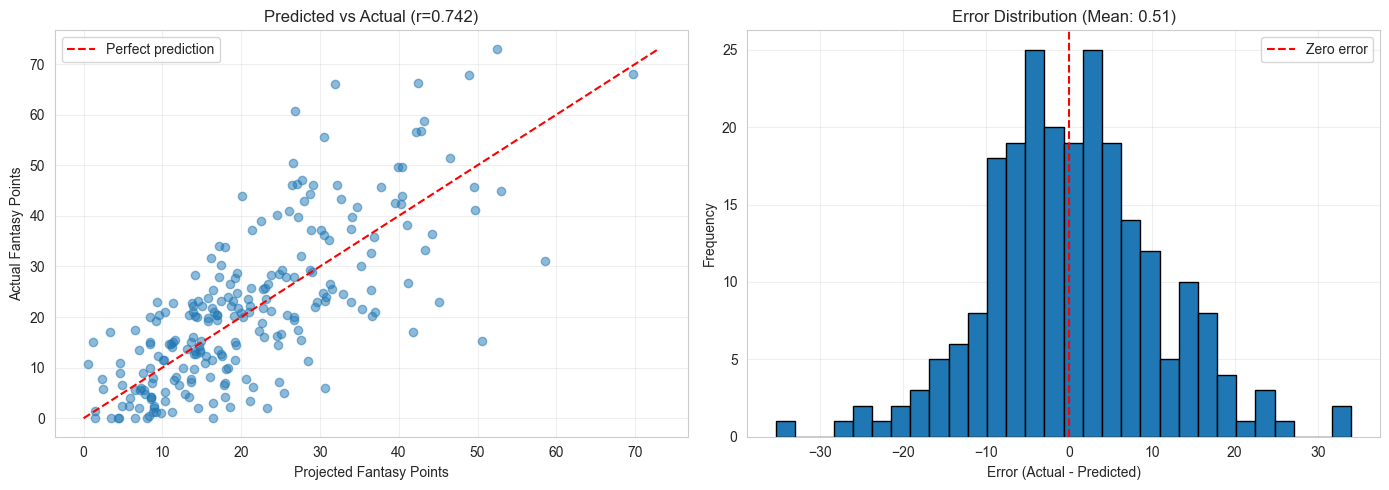

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(merged['projected_fpts'], merged['actual_fpts'], alpha=0.5)
axes[0].plot([0, merged['actual_fpts'].max()], [0, merged['actual_fpts'].max()], 'r--', label='Perfect prediction')
axes[0].set_xlabel('Projected Fantasy Points')
axes[0].set_ylabel('Actual Fantasy Points')
axes[0].set_title(f'Predicted vs Actual (r={corr:.3f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(merged['error'], bins=30, edgecolor='black')
axes[1].axvline(0, color='red', linestyle='--', label='Zero error')
axes[1].set_xlabel('Error (Actual - Predicted)')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f"Error Distribution (Mean: {merged['error'].mean():.2f})")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [41]:
print("Top 10 overestimates (predicted too high):")
print(merged.sort_values('error')[['playerName', 'team', 'pos', 'projected_fpts', 'actual_fpts', 'error']].head(10))

print("\nTop 10 underestimates (predicted too low):")
print(merged.sort_values('error', ascending=False)[['playerName', 'team', 'pos', 'projected_fpts', 'actual_fpts', 'error']].head(10))

Top 10 overestimates (predicted too high):
             playerName team pos  projected_fpts  actual_fpts      error
13        Mark Williams  CHA   C       50.558643        15.25 -35.308643
10        Miles Bridges  CHA  PF       58.511024        31.00 -27.511024
30           Malik Monk  SAC  SG       41.750263        17.00 -24.750263
40     D'Angelo Russell  BKN  PG       30.638998         6.00 -24.638998
9          Devin Booker  PHO  SG       45.066795        23.00 -22.066795
156        Jake LaRavia  MEM  SF       23.338018         2.00 -21.338018
70        Malik Beasley  DET  SG       25.465073         5.00 -20.465073
134        Caris LeVert  CLE  SG       21.174076         3.50 -17.674076
103  Zaccharie Risacher  ATL  SF       24.837578         7.25 -17.587578
76      Malcolm Brogdon  WAS  PG       28.516668        11.25 -17.266668

Top 10 underestimates (predicted too low):
                  playerName team pos  projected_fpts  actual_fpts      error
47        Michael Porter Jr.  DE

In [42]:
print("Highest absolute errors:")
print(merged.sort_values('abs_error', ascending=False)[['playerName', 'team', 'pos', 'projected_fpts', 'actual_fpts', 'error', 'abs_error']].head(10))

Highest absolute errors:
             playerName team pos  projected_fpts  actual_fpts      error  \
13        Mark Williams  CHA   C       50.558643        15.25 -35.308643   
47   Michael Porter Jr.  DEN  SF       31.954611        66.00  34.045389   
64         Bobby Portis  MIL  PF       26.852573        60.75  33.897427   
10        Miles Bridges  CHA  PF       58.511024        31.00 -27.511024   
45       Onyeka Okongwu  ATL   C       30.526423        55.50  24.973577   
30           Malik Monk  SAC  SG       41.750263        17.00 -24.750263   
40     D'Angelo Russell  BKN  PG       30.638998         6.00 -24.638998   
49             Naz Reid  MIN   C       26.554335        50.50  23.945665   
118  Brandin Podziemski   GS  SG       20.110958        44.00  23.889042   
5       Anthony Edwards  MIN  SG       42.490189        66.25  23.759811   

     abs_error  
13   35.308643  
47   34.045389  
64   33.897427  
10   27.511024  
45   24.973577  
30   24.750263  
40   24.638998  
49

## Performance by Salary Tier

In [43]:
merged['salary_tier'] = pd.cut(merged['salary'], bins=[0, 4000, 6000, 8000, 15000], labels=['Low', 'Mid', 'High', 'Elite'])

tier_stats = merged.groupby('salary_tier').agg({
    'playerID': 'count',
    'projected_fpts': 'mean',
    'actual_fpts': 'mean',
    'abs_error': 'mean',
    'pct_error': 'mean'
}).rename(columns={'playerID': 'count'})

print("Performance by salary tier:")
print(tier_stats)

Performance by salary tier:
             count  projected_fpts  actual_fpts  abs_error   pct_error
salary_tier                                                           
Low            106       11.766475    11.811321   6.282242  117.598158
Mid             75       21.773977    23.050000   7.979035   65.091751
High            28       33.542869    33.410714  11.573796   49.532403
Elite           25       43.617964    44.510000  12.017952   34.701219


C:\Users\antho\AppData\Local\Temp\ipykernel_45820\14600087.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tier_stats = merged.groupby('salary_tier').agg({


<Figure size 1000x500 with 0 Axes>

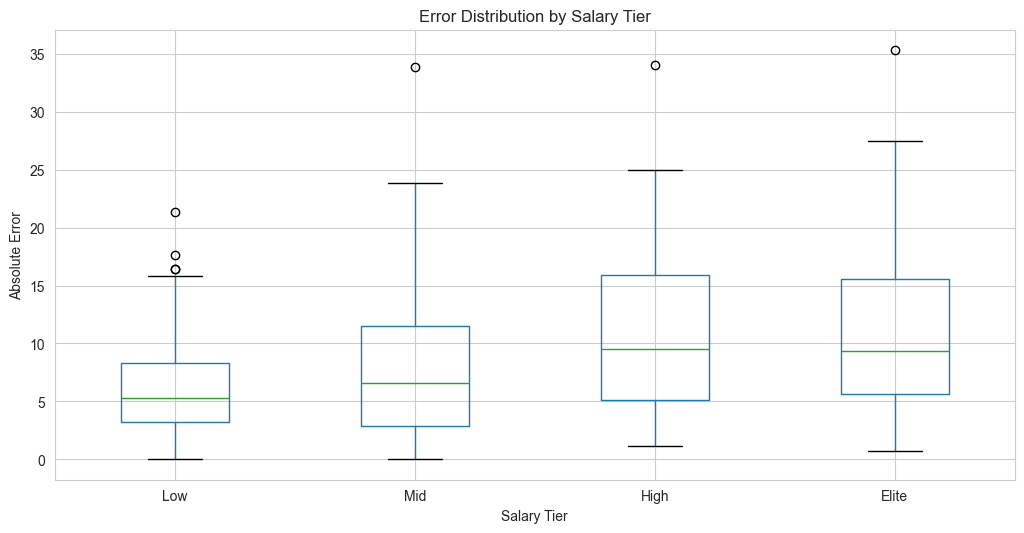

In [44]:
plt.figure(figsize=(10, 5))
merged.boxplot(column='abs_error', by='salary_tier')
plt.xlabel('Salary Tier')
plt.ylabel('Absolute Error')
plt.title('Error Distribution by Salary Tier')
plt.suptitle('')
plt.show()

## Compare Per-Player vs Slate Model Performance

Analyze which players benefit from per-player models vs slate models.

In [45]:
training_stats_merge = merged.merge(
    training_stats_df[['playerID', 'num_games']],
    on='playerID',
    how='left'
)

print("Error by number of training games:")
print(training_stats_merge[['playerName', 'num_games', 'abs_error', 'actual_fpts']].sort_values('num_games', ascending=False).head(20))

Error by number of training games:
                   playerName  num_games  abs_error  actual_fpts
35                Rudy Gobert         49  10.631905        43.25
44            Jaden McDaniels         49   4.719553        26.50
93   Nickeil Alexander-Walker         49   3.518681        22.25
70              Malik Beasley         49  20.465073         5.00
47         Michael Porter Jr.         49  34.045389        66.00
116         Scotty Pippen Jr.         49   8.293713        16.25
180               Ron Holland         49   1.496447        12.75
141          Julian Strawther         49   3.555830        13.50
129              Jaylen Wells         49   6.503864        15.00
65            Christian Braun         48  19.148893        46.25
75              Aaron Wiggins         48  10.844746        28.00
179        Carlton Carrington         48  16.445377        39.00
112            Taurean Prince         48   1.299041        15.00
158             Georges Niang         48   0.381251    

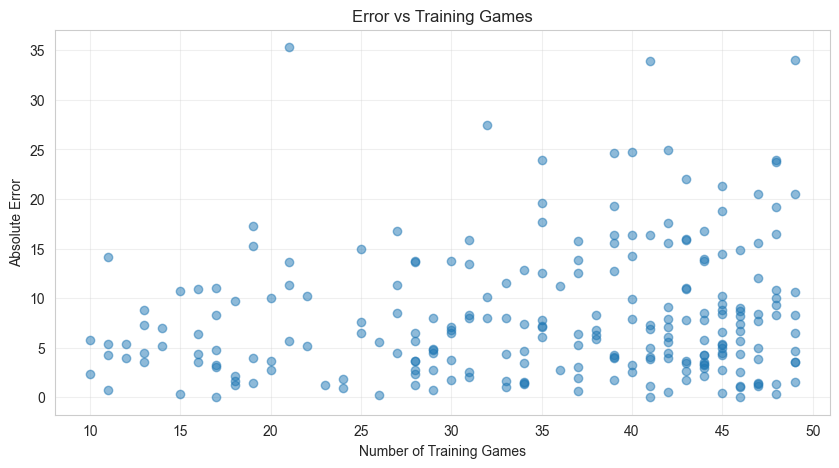


Correlation between training games and error: 0.152


In [46]:
plt.figure(figsize=(10, 5))
plt.scatter(training_stats_merge['num_games'], training_stats_merge['abs_error'], alpha=0.5)
plt.xlabel('Number of Training Games')
plt.ylabel('Absolute Error')
plt.title('Error vs Training Games')
plt.grid(True, alpha=0.3)
plt.show()

corr_games_error = training_stats_merge[['num_games', 'abs_error']].corr().iloc[0, 1]
print(f"\nCorrelation between training games and error: {corr_games_error:.3f}")

## Summary Statistics

In [47]:
print(f"Date: {TARGET_DATE}")
print(f"Players evaluated: {len(merged)}")
print(f"Players with models: {players_with_models}")
print(f"Players without models: {players_without_models}")
print(f"\nPerformance Metrics:")
print(f"  MAPE: {mape:.2f}%")
print(f"  RMSE: {rmse:.2f}")
print(f"  Correlation: {corr:.3f}")
print(f"\nError Statistics:")
print(f"  Mean error: {merged['error'].mean():.2f}")
print(f"  Mean absolute error: {merged['abs_error'].mean():.2f}")
print(f"  Median absolute error: {merged['abs_error'].median():.2f}")
print(f"  Std dev of error: {merged['error'].std():.2f}")
print(f"\nProjection Range:")
print(f"  Min projected: {merged['projected_fpts'].min():.1f}")
print(f"  Max projected: {merged['projected_fpts'].max():.1f}")
print(f"  Mean projected: {merged['projected_fpts'].mean():.1f}")
print(f"\nActual Range:")
print(f"  Min actual: {merged['actual_fpts'].min():.1f}")
print(f"  Max actual: {merged['actual_fpts'].max():.1f}")
print(f"  Mean actual: {merged['actual_fpts'].mean():.1f}")

Date: 20250205
Players evaluated: 234
Players with models: 322
Players without models: 38

Performance Metrics:
  MAPE: 82.96%
  RMSE: 10.43
  Correlation: 0.742

Error Statistics:
  Mean error: 0.51
  Mean absolute error: 8.07
  Median absolute error: 6.43
  Std dev of error: 10.44

Projection Range:
  Min projected: 0.6
  Max projected: 69.7
  Mean projected: 21.0

Actual Range:
  Min actual: 0.0
  Max actual: 73.0
  Mean actual: 21.5
